In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
class FlexibleFastAgent:
    def __init__(self, initial_balance, initial_date):
        self.balance = initial_balance
        self.date = initial_date
        self.daily_balance = []
        self.shares = {symbol: 0 for symbol in symbols}
        self.performance_history = {symbol: [] for symbol in symbols} # Gain from selling stocks obtained by sold quantity*(price - avg book value price)
        self.wait_time = {symbol: 0 for symbol in symbols}  # Start with a wait time for each firm
        self.weights = {symbol: 1/len(symbols) for symbol in symbols} # Start with an equal weight for each firm
        self.share_val = {symbol: [0, 0] for symbol in symbols} #Start with 0 book value and 0 share value for each firm
        self.shares_history = {symbol: [] for symbol in symbols} #Add buy and sell number of shares and current prices

    def set_current_date(self, current_date):
        self.date = current_date


    def update_shares_history(self, symbol, buy_sell, quantity, price):
        self.shares_history[symbol].append({
            'type' : buy_sell,
            'quantity': quantity,
            'price': price,
            'date': self.date
        })

    def decide(self, prices, short_mas, long_mas, symbols, expected_trs):
        self.daily_balance.append(self.value(prices))
        expected_returns = {}
        for symbol in symbols:
            expected_returns[symbol] = long_mas[symbol] - short_mas[symbol] - expected_trs[symbol]

        max_3_returns = sorted(list(expected_returns.values()))[-3:]  # Limiting to buy option with only maximum 3 positive returns
        total_expected_positive = sum([x for x in max_3_returns if x > 0 ])
        total_expected_negative = sum([x for x in expected_returns.values() if x < 0])

        for symbol in symbols:
            price = prices[symbol]
            short_ma = short_mas[symbol]
            long_ma = long_mas[symbol]
            #expected_tr = expected_trs[symbol]
            expected_return = expected_returns[symbol]

            if self.wait_time[symbol] > 0:
                self.wait_time[symbol] -= 1  # Reduce wait time for next decision
                continue  # Skip decision if waiting


            if expected_return > 0 and (expected_return in (max_3_returns)) and self.balance > 0:  # Buy signal
                weight = expected_return / total_expected_positive
                self.weights[symbol] = weight
                quantity = int(weight * (self.balance // price))
                if quantity > 0:
                    self.buy(price, quantity, symbol)

            elif expected_return < 0 and self.shares[symbol] > 0:  # Sell signal
                self.weights[symbol] = -1 # Sell all shares
                quantity = self.shares[symbol]
                if quantity > 0:
                    self.sell(price, quantity, symbol)


    def buy(self, price, quantity, symbol):
        total_cost = price * quantity
        if total_cost <= self.balance:
            self.shares[symbol] += quantity
            self.balance -= total_cost
            self.share_val[symbol][0] -= total_cost
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'buy', quantity, price)


    def sell(self, price, quantity, symbol):
        if quantity <= self.shares[symbol]:
            self.update_performance(symbol, price, quantity)
            self.share_val[symbol][0] *= (1-quantity/self.shares[symbol])
            self.shares[symbol] -= quantity
            self.balance += price * quantity
            self.share_val[symbol][1] = self.shares[symbol] * price
            self.update_shares_history(symbol, 'sell', quantity, price)


    def update_performance(self, symbol, price, quantity):
        gain = quantity*(price + self.share_val[symbol][0]/self.shares[symbol]) # Calculate gain using average shares value from the book value
        self.performance_history[symbol].append({'gain': gain, 'date': self.date})

        if gain > 0: # Adjust wait time based on performance
            self.wait_time[symbol] = max(0, self.wait_time[symbol] - 1)  # Shorten wait time if expecting gain
        else:
            self.wait_time[symbol] += 1  # Increase wait time if expecting lose

    def value(self, current_prices):
        total_value = self.balance
        for symbol in symbols:
            total_value += self.shares[symbol] * current_prices[symbol]
        return total_value

In [3]:
short_window = 20  # Short-term moving average
long_window = 50   # Long-term moving average

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $15010.06


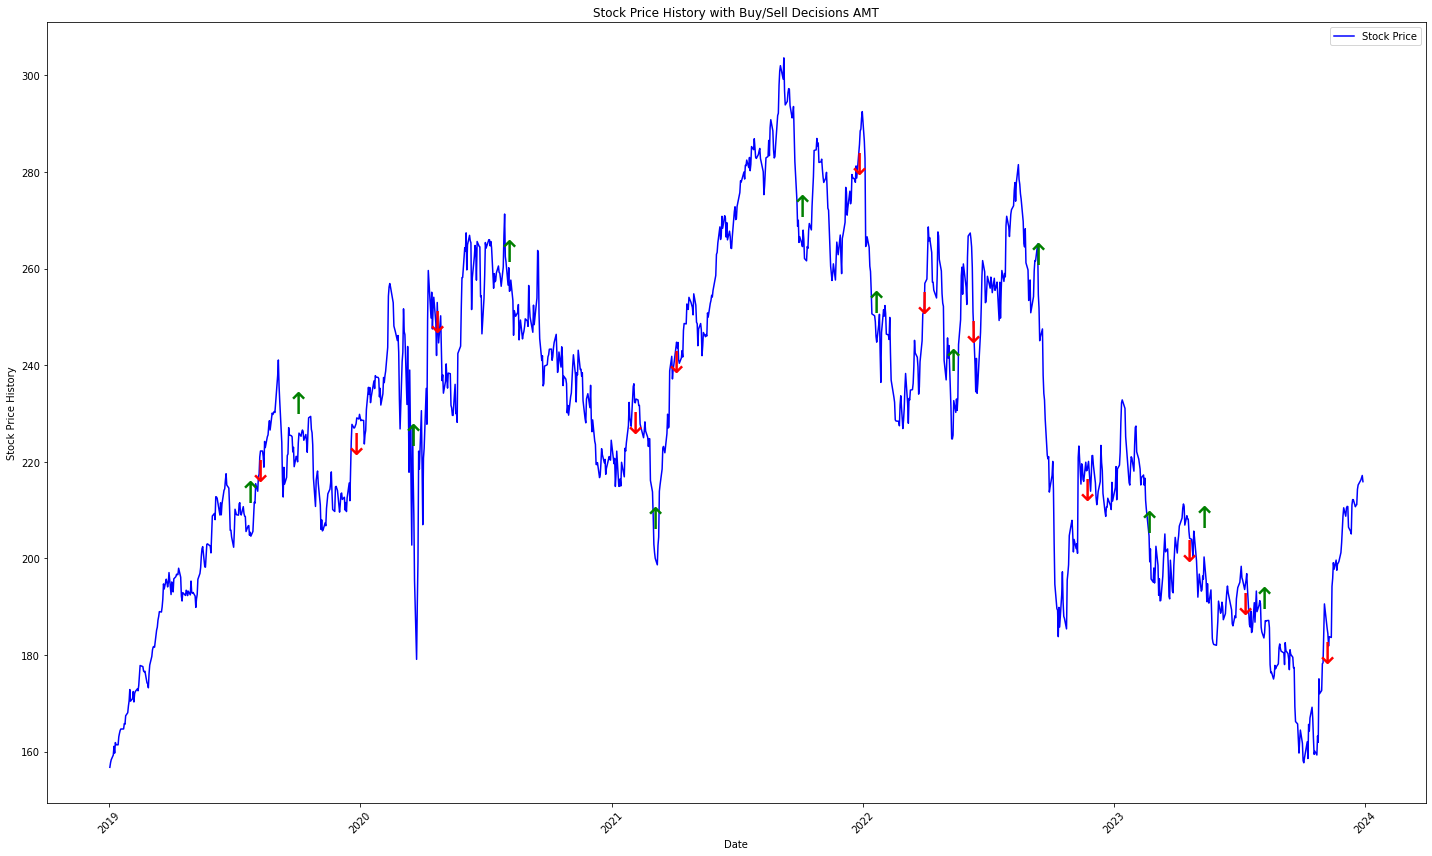

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $17725.05


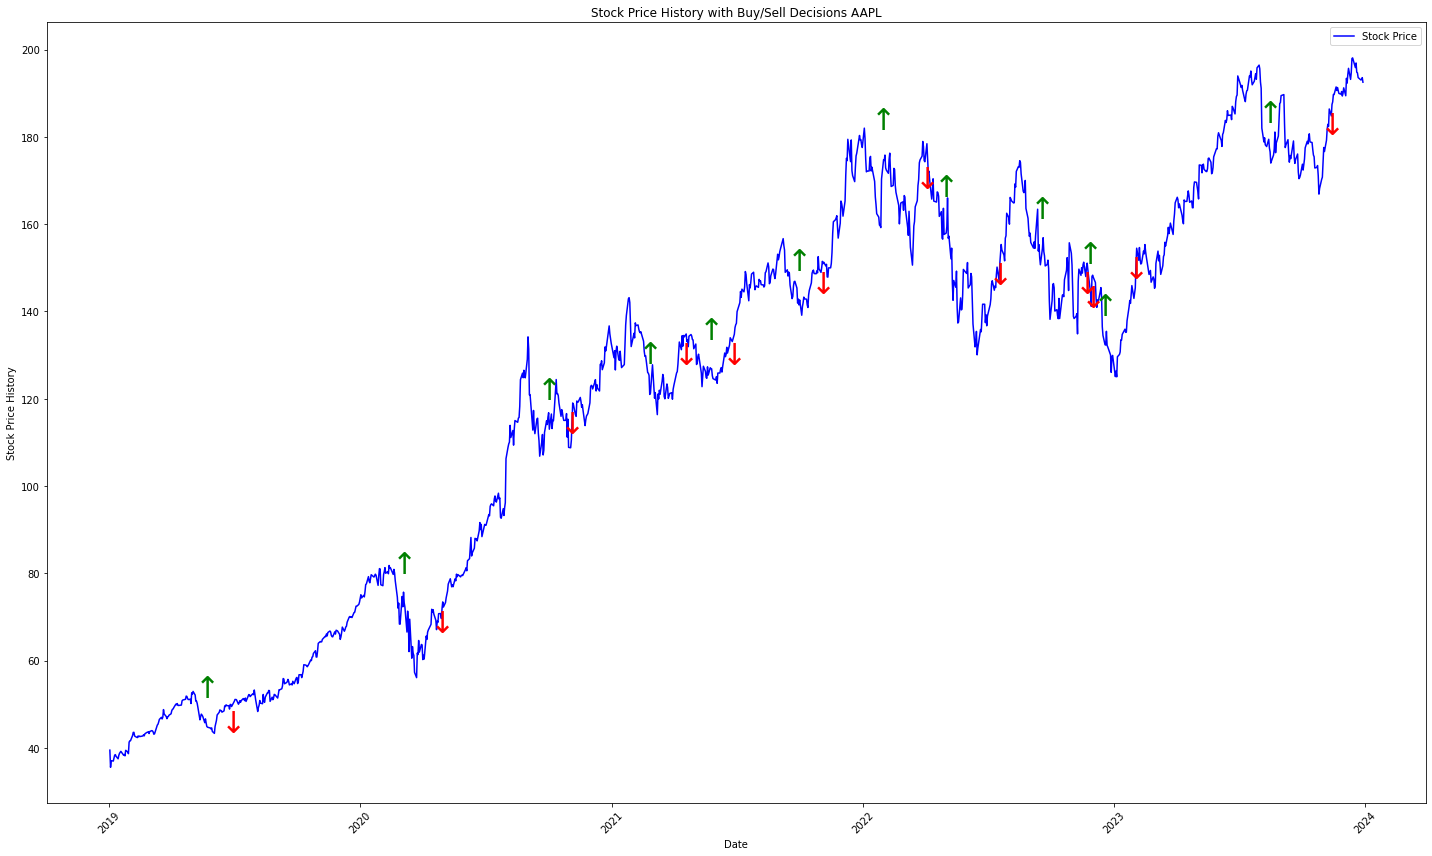

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $23100.83


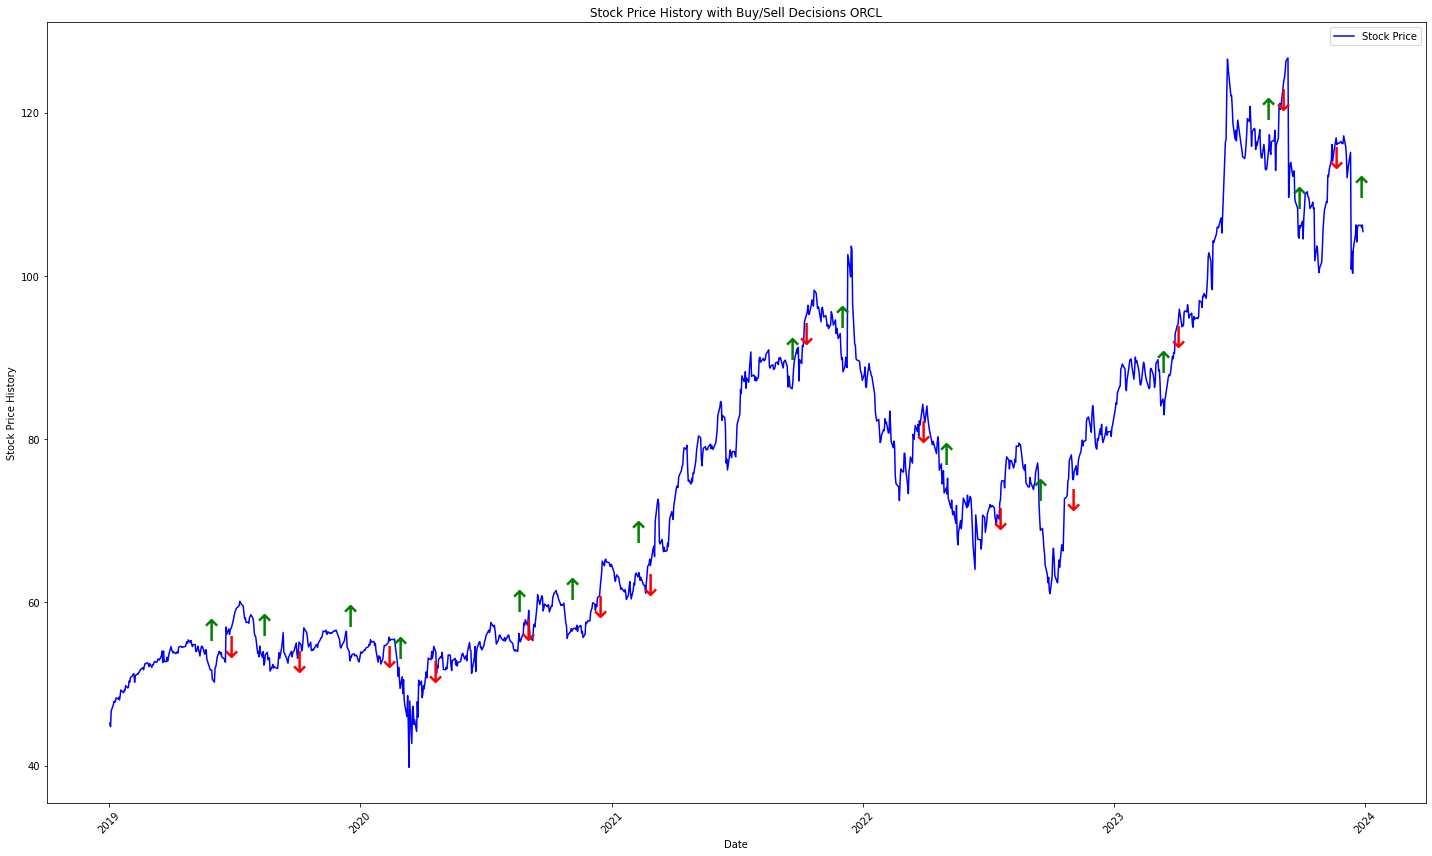

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $18591.89


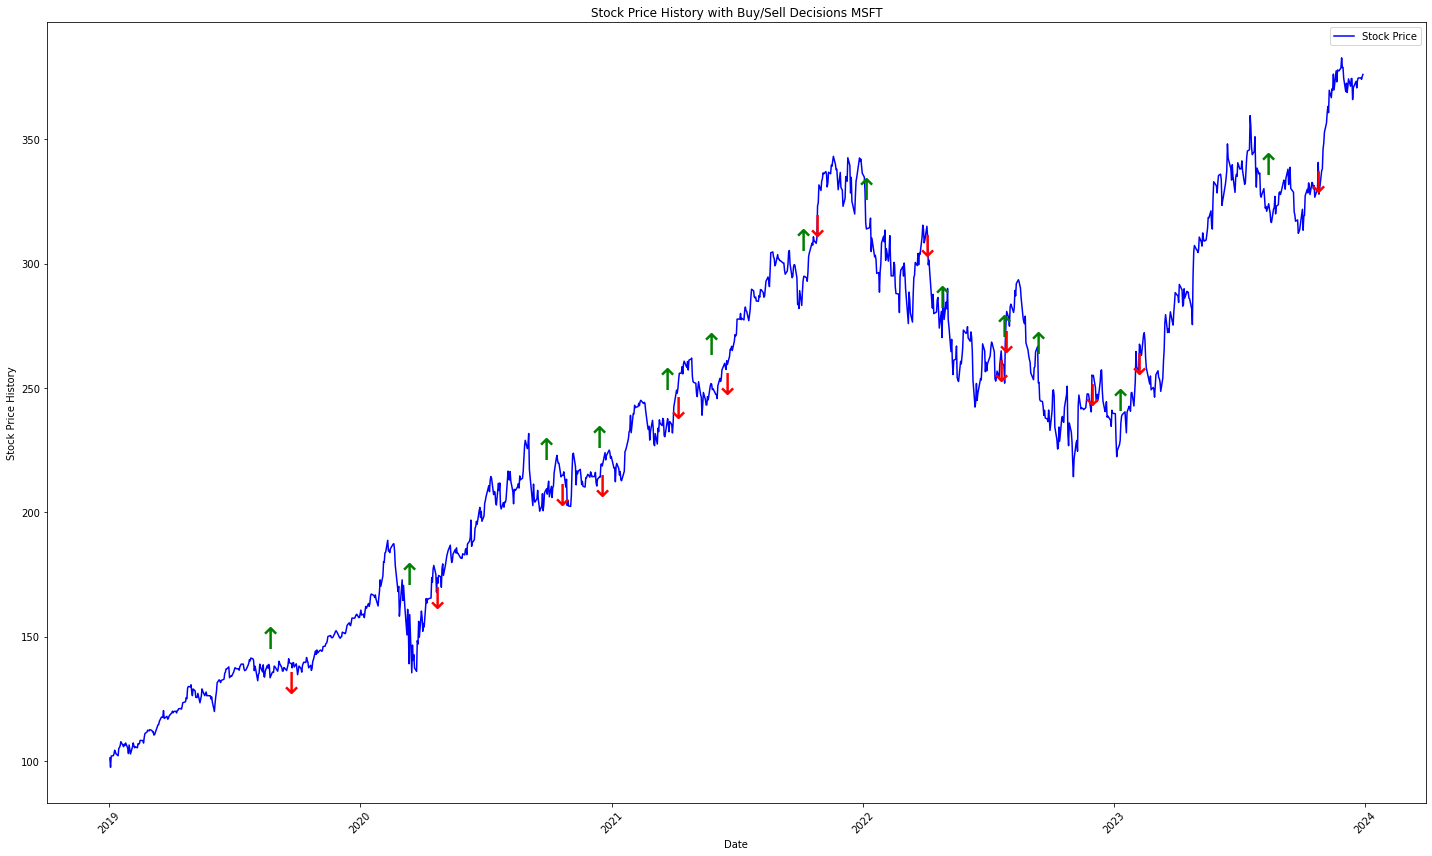

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $15010.06


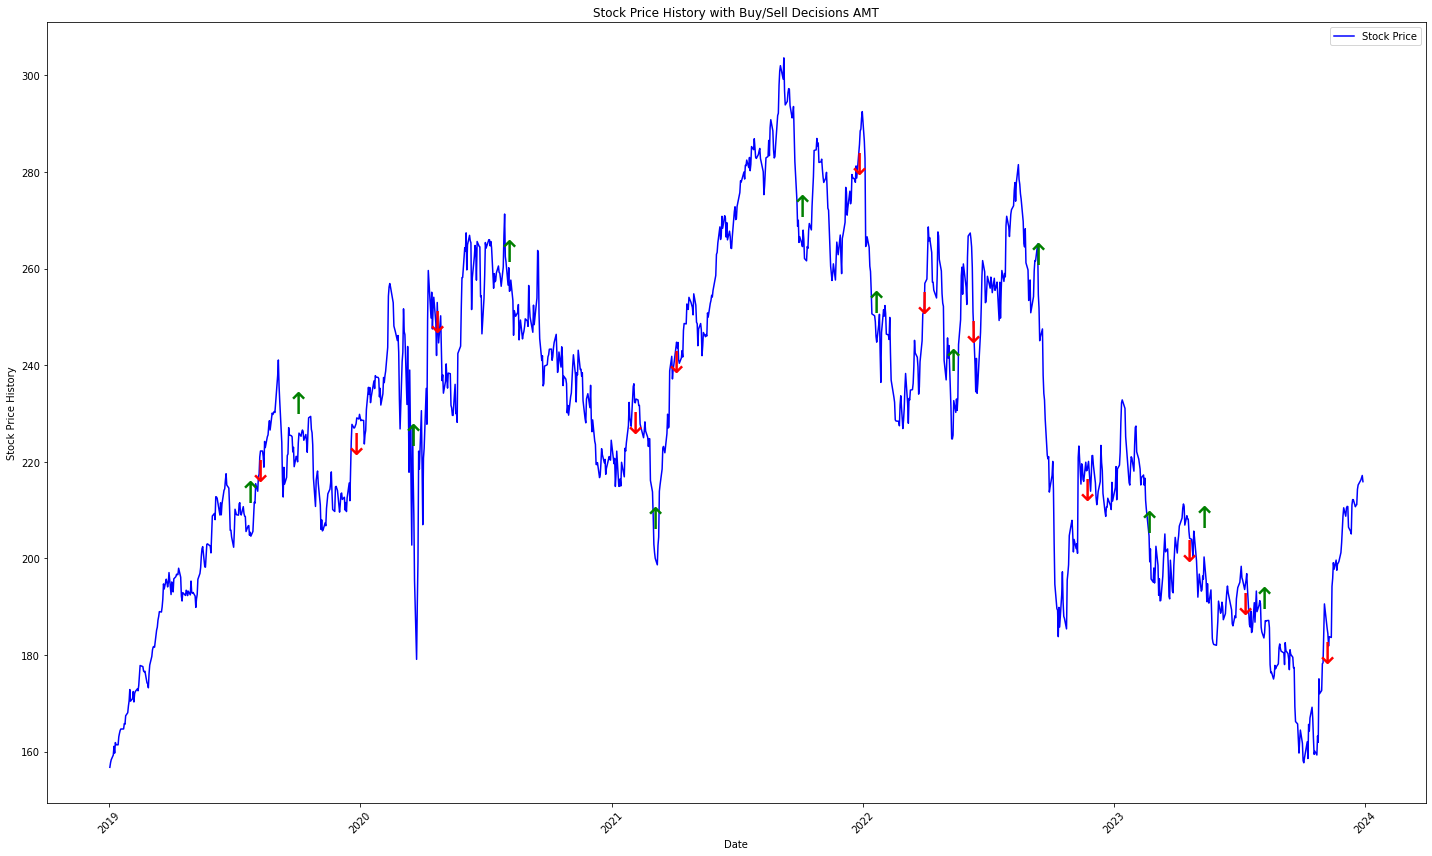

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $15838.02


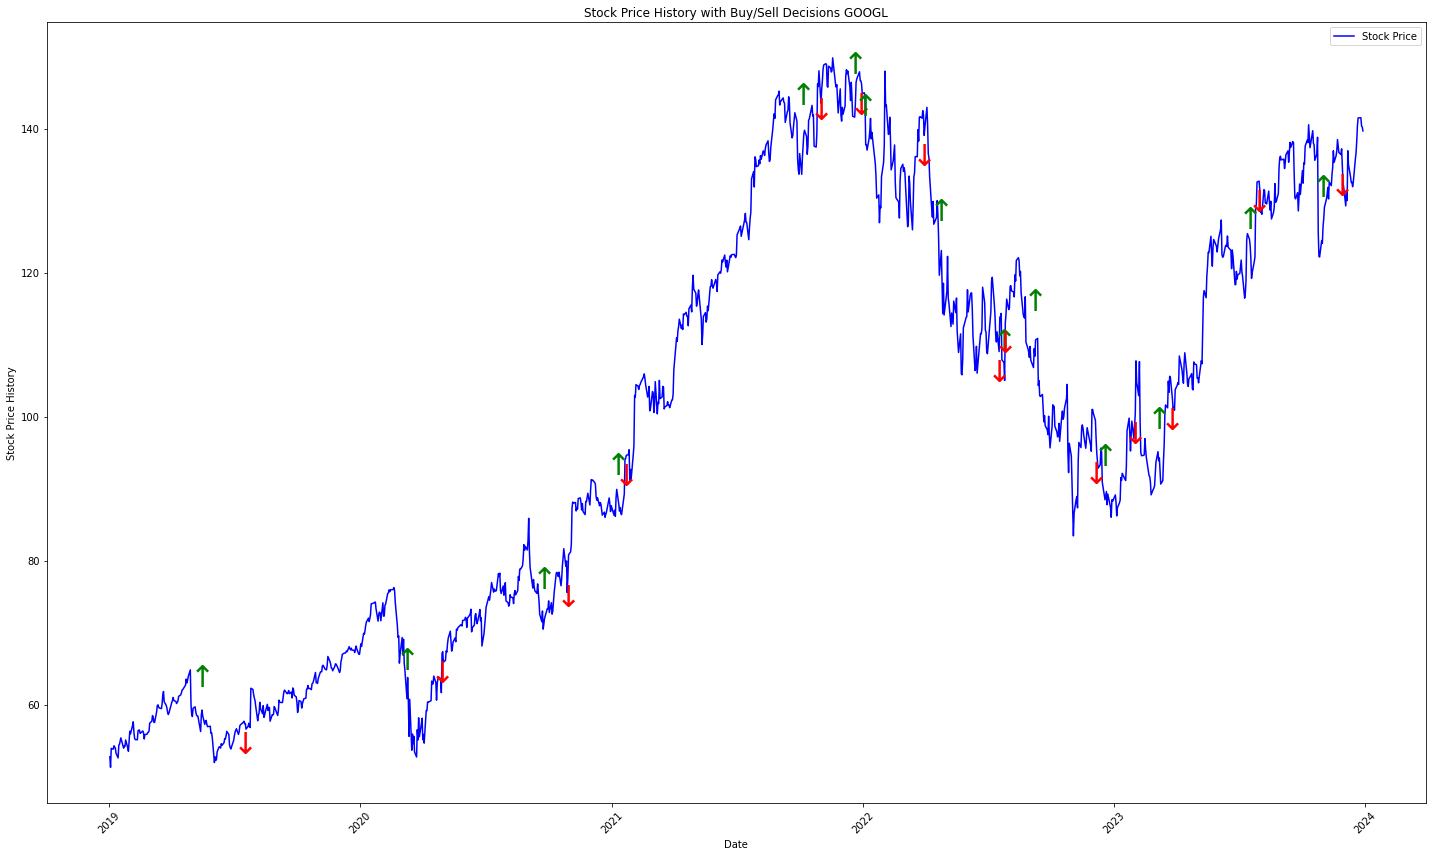

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $19199.36


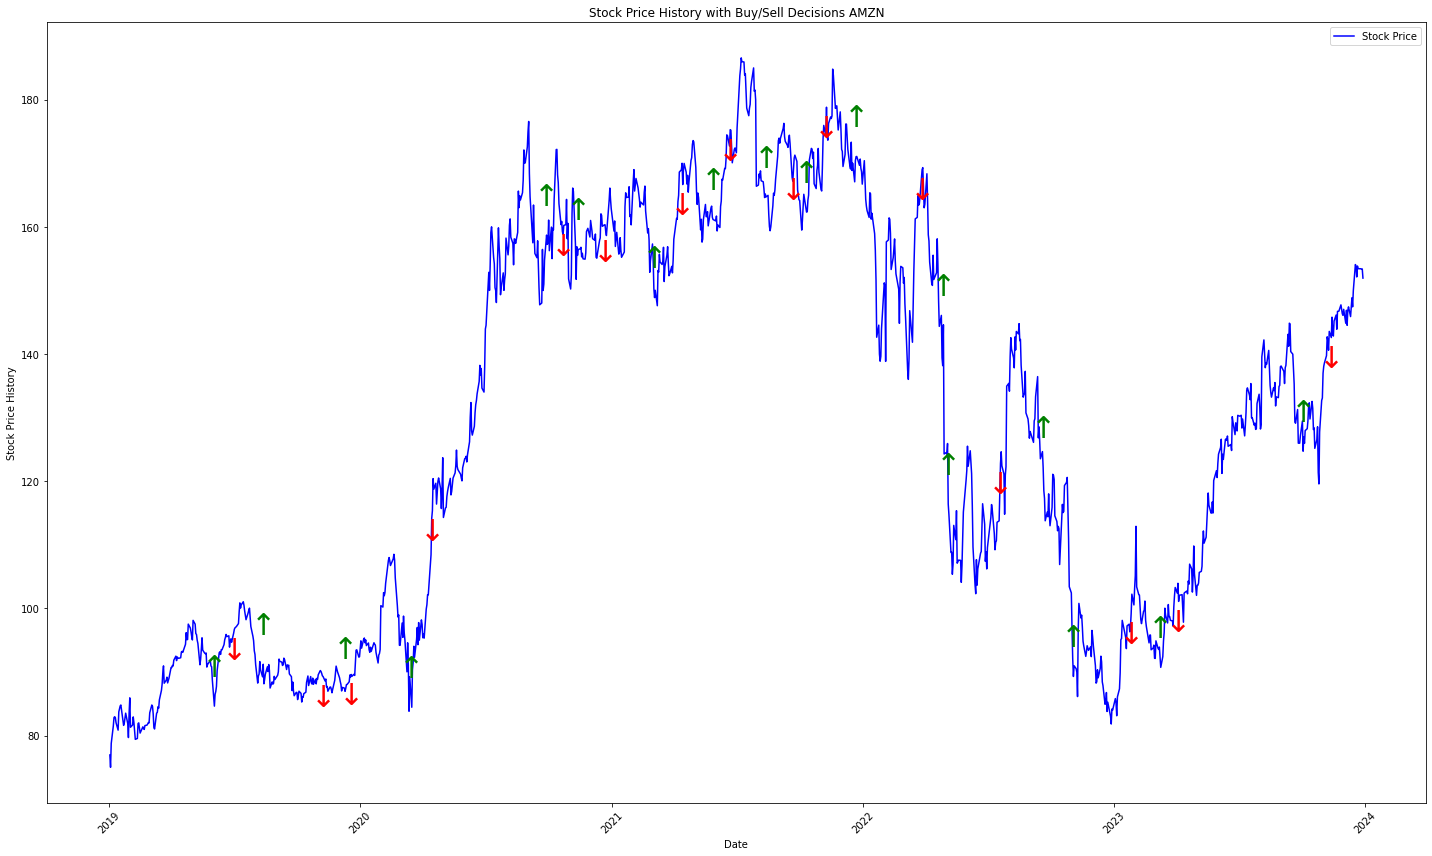

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $11616.82


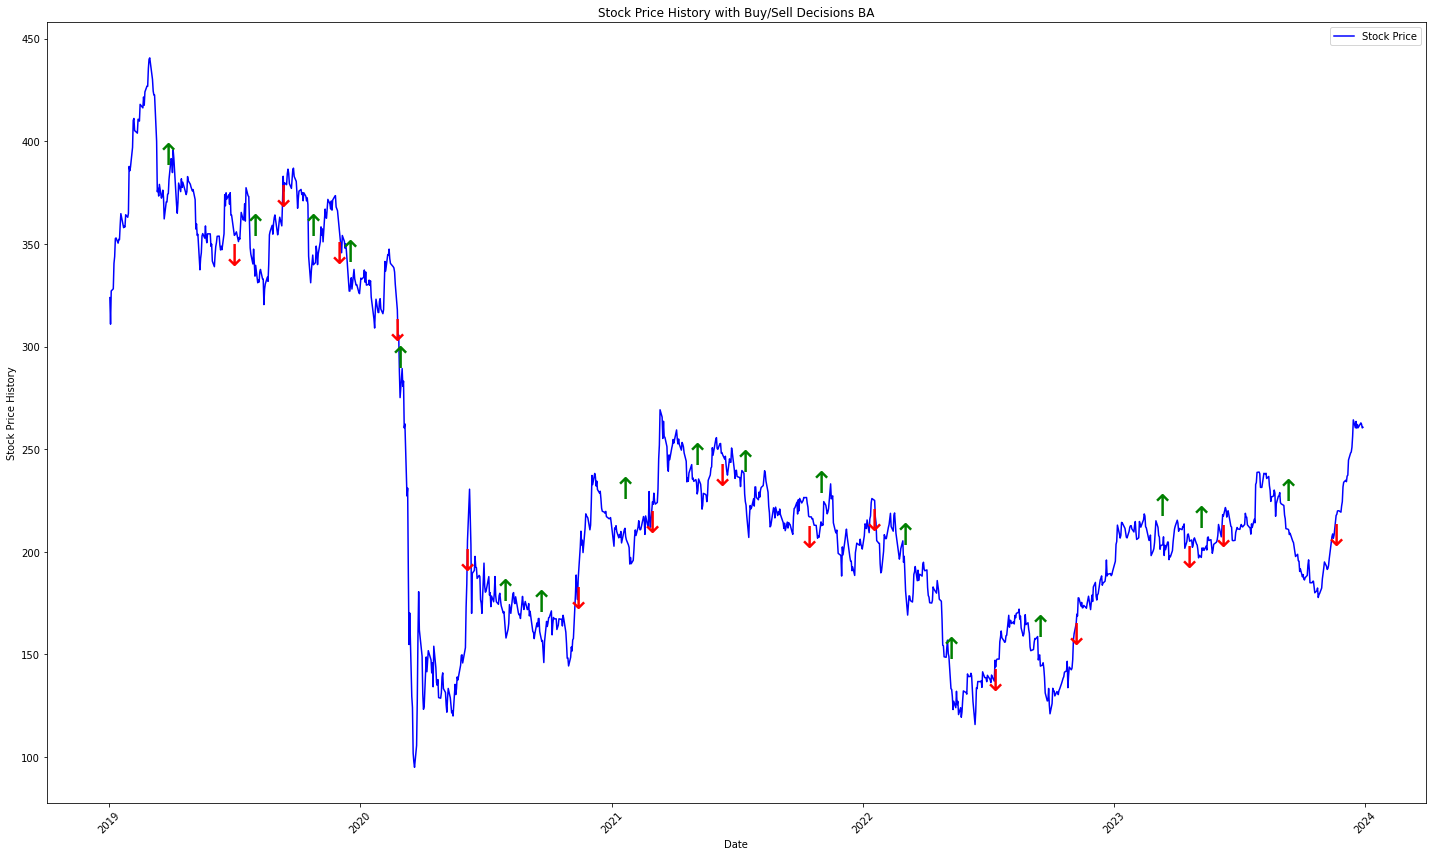

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $13490.22


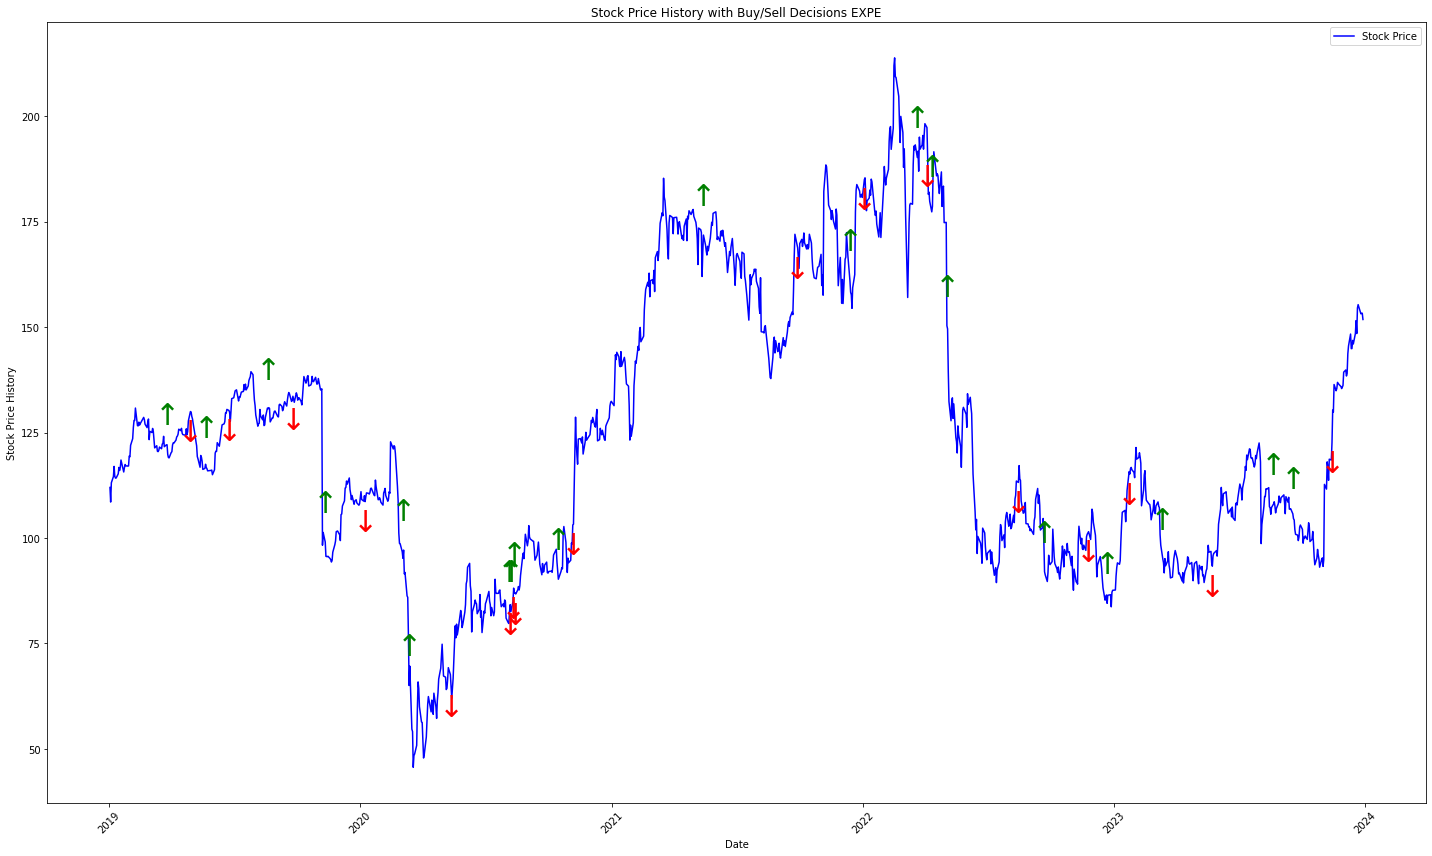

[*********************100%***********************]  1 of 1 completed
(1258, 6)
Fast Agent Final Portfolio Value: $24567.84


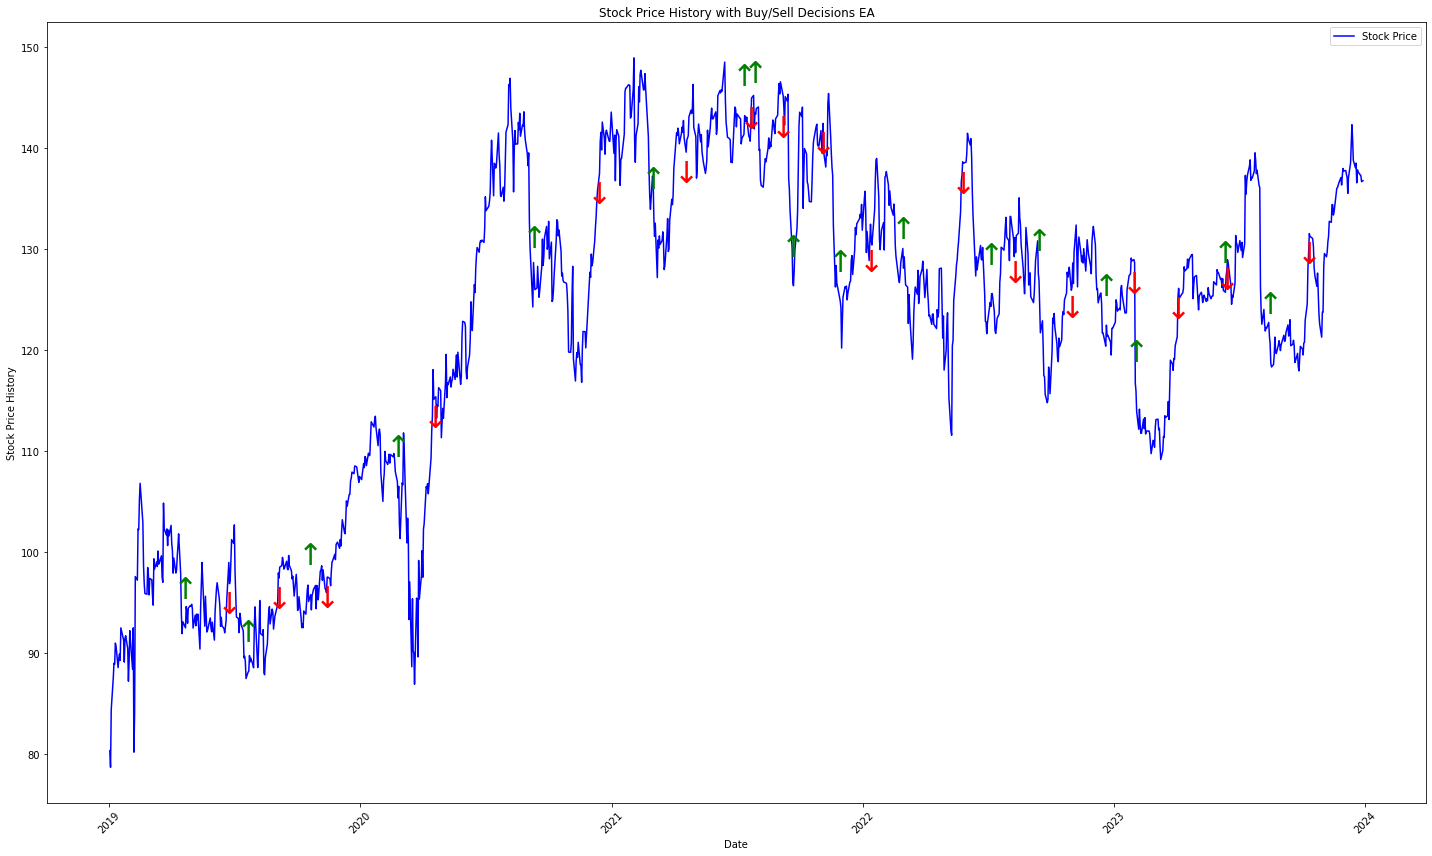

In [4]:
for symbols in [['AMT'], ['AAPL'], ['ORCL'], ['MSFT'], ['AMT'], ['GOOGL'], ['AMZN'], ['BA'], ['EXPE'], ['EA']]:

    data = {} # Download historical stock data for multiple firms
    for symbol in symbols:
        data[symbol] = yf.download(symbol, start='2019-01-01', end='2024-01-01')

    print(data[symbols[0]].shape)   
    expected_trs = {symbol: 0 for symbol in symbols}

    initial_balance = 10000
    initial_date = data[symbols[0]].index[long_window]
    fast_agent = FlexibleFastAgent(initial_balance, initial_date)

    for i in range(long_window, len(data[symbols[0]])):
        current_date = data[symbols[0]].index[i]
        fast_agent.set_current_date(current_date)

        current_prices = {symbol: data[symbol]['Close'].iloc[i] for symbol in symbols}
        short_mas = {symbol: data[symbol]['Close'].rolling(window=short_window).mean().iloc[i] for symbol in symbols}
        long_mas = {symbol: data[symbol]['Close'].rolling(window=long_window).mean().iloc[i] for symbol in symbols}

        fast_agent.decide(current_prices, short_mas, long_mas, symbols, expected_trs)    # Fast Agent Decision for each symbol


    fast_final_value = fast_agent.value(current_prices)
    print(f"Fast Agent Final Portfolio Value: ${fast_final_value:.2f}")

    df2 = pd.DataFrame(fast_agent.shares_history[symbols[0]])

    df1 = data[symbols[0]].reset_index()

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 12))

    # Plot value from df1
    ax.plot(df1['Date'], df1['Close'], label='Stock Price', color='blue')

    # Mark buy/sell with arrows from df2
    for idx, row in df2.iterrows():
        if row['type'] == 'buy':
            ax.annotate('↑', (row['date'], df1.loc[df1['Date'] == row['date'], 'Close'].values[0]),
                        textcoords="offset points", xytext=(0, 30), ha='center', color='green', fontsize=30)
        elif row['type'] == 'sell':
            ax.annotate('↓', (row['date'], df1.loc[df1['Date'] == row['date'], 'Close'].values[0]),
                        textcoords="offset points", xytext=(0, -30), ha='center', color='red', fontsize=30)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock Price History')
    ax.set_title(f'Stock Price History with Buy/Sell Decisions {symbols[0]}')
    ax.legend()

    # Rotate date labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show plot
    plt.show()